<center><h1>Projet Robotique</h1></center>
<center><h2>Classification via CNN</h2></center>

# Importation des librairies

In [1]:
!pip install bayesian-optimization

In [1]:
import os
from google.colab import drive

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from bayes_opt import BayesianOptimization

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten
from keras.optimizers import Adam
from keras.api._v2.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')
# disable tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Configaration GPU

In [2]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
  print("Found GPU at:{}".format(device_name))
else:
  device_name="/device:CPU:0"
  print("No GPU")

Found GPU at:/device:GPU:0


# Importation du dataset

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Robotique/preprocessed_data.csv")

df

,MILLISEC,Accelerometer RKN^ accX,Accelerometer RKN^ accY,Accelerometer RKN^ accZ,Accelerometer HIP accX,Accelerometer HIP accY,Accelerometer HIP accZ,Accelerometer LUA^ accX,Accelerometer LUA^ accY,Accelerometer LUA^ accZ,...,LOCATION TAG4 X,LOCATION TAG4 Y,LOCATION TAG4 Z,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,-1.585284,0.146747,0.337532,-1.410530,0.693260,0.434434,0.074936,-0.199117,0.621667,-0.455638,...,0.147947,0.811792,0.186199,0,0,0,0,0,0,0
1,-1.585185,0.263802,0.342378,-1.626921,0.626338,0.487110,0.200034,-0.108635,0.598101,-0.542260,...,0.147947,0.812691,0.178270,0,0,0,0,0,0,0
2,-1.585083,0.194202,0.371457,-1.735116,0.470187,0.527630,0.179184,-0.099275,0.709202,-0.572130,...,0.147947,0.814490,0.172322,0,0,0,0,0,0,0
3,-1.584985,0.058164,0.153369,-1.616313,0.618902,0.523578,0.210459,-0.152316,0.729402,-0.593039,...,0.147947,0.816289,0.172322,0,0,0,0,0,0,0
4,-1.584886,0.247984,0.290684,-1.705415,0.570570,0.535734,0.161809,-0.189757,0.709202,-0.634857,...,0.149055,0.818988,0.176287,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606043,1.407215,0.640278,0.298761,-0.141884,0.358651,0.102168,0.787298,0.418657,0.540867,-0.067329,...,0.129671,0.139901,0.208006,0,0,0,0,0,0,0
606044,1.407317,0.437804,0.297145,-0.020960,0.291729,0.102168,0.776873,0.452977,0.483633,-0.195770,...,0.129117,0.138102,0.206023,0,0,0,0,0,0,0
606045,1.407416,0.678242,0.240604,-0.001866,0.143014,0.110272,0.915871,0.393696,0.503833,-0.195770,...,0.129117,0.136303,0.202059,0,0,0,0,0,0,0
606046,1.407514,1.155955,0.159831,-0.046417,0.098399,0.256145,0.780348,0.362495,0.577900,-0.276418,...,0.129671,0.134504,0.200076,0,0,0,0,0,0,0


# Fonctions diverses

# Fonctions de feature selection

In [4]:
def dim_reduction(df, n):
  pca = PCA(n_components=n)
  pca.fit(df)
  reducted_df = pca.fit_transform(df)
  columns_name = ['column'+str(i) for i in range(1, pca.n_components_+1)]
  return pd.DataFrame(reducted_df, columns=columns_name)


In [5]:
def correlation(dataset, cor):
    df = dataset.copy()
    col_corr = set()  # For storing unique value
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > cor: # absolute values to handle positive and negative correlations
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    df.drop(col_corr,axis = 1,inplace = True)
    return df

## Fonction de segmentation du dataset  

In [6]:
def data_segmentation(dataCollection, window_size, label): # segment the data and create a dataset with locomotion classes as labels

    loco_i = dataCollection.columns.get_loc(label)
    #convert the data frame to numpy array
    data = dataCollection.to_numpy()
    #segment the data
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0

    while start + window_size - 1 < n:
        end = start + window_size-1
        if data[start][loco_i] == data[end][loco_i] and data[start][-1] == data[end][-1] : # if the frame contains the same activity and from the file
            X.append(data[start:(end+1),:])
            y.append(data[start][loco_i])
            start += window_size//2 # 50% overlap
        else: # if the frame contains different activities or from different objects, find the next start point
            while start + window_size-1 < n:
                if data[start][loco_i] != data[start+1][loco_i]:
                    break
                start += 1
            start += 1

    return np.asarray(X), np.asarray(y)

## Fonction d'entrainement du modèle

In [7]:
from keras.layers import Conv1D, MaxPooling1D

def cnn_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp, v):
    nbn_l = int(nbn_l)
    nbn_d = int(nbn_d)
    bs = int(bs)
    with tf.device(device_name):
        model = Sequential()
        model.add(Conv1D(filters=nbn_l, kernel_size=3, activation='relu', input_shape=X_train[0].shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=nbn_l//2, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(nbn_d, activation='elu'))
        model.add(Dropout(dp))
        model.add(Dense(nbn_l//2, activation='elu'))
        model.add(Dropout(dp))
        model.add(Dense(5, activation='softmax'))

        model.compile(optimizer=Adam(learning_rate=lr),
                      loss='categorical_crossentropy',
                      metrics = [tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.FalsePositives(name='fp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.FalseNegatives(name='fn'),
                        'accuracy',
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')])

        checkpointer = ModelCheckpoint(filepath='cnn_model_best.keras', monitor='val_accuracy', verbose=0, save_best_only=True)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5)

        history = model.fit(X_train, y_train, batch_size=bs, epochs=100, verbose=v, validation_data=(X_val, y_val), callbacks=[checkpointer, early_stopping])
        return history, model


## Fonction de la pipeline à utiliser

In [14]:
def pipeline(method, tresh, nbn_l, nbn_d, lr, bs, dp):
    if method <= 1:
        dataset = dim_reduction(df[df.columns[:-7]], tresh)
    elif method <= 2:
        dataset = correlation(df[df.columns[:-7]], tresh)

    labels = df[df.columns[-7:]]
    dataset = pd.concat([dataset, labels], axis=1)

    X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

    y = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

    history, model = cnn_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp, 0)
    acc = history.history['val_accuracy'][-1]

    return acc

# Affinage de la pipeline via l'optimisation Bayesienne

In [ ]:
pbounds = {
    'method': (0, 2),
    'tresh': (0.1, 0.99),
    'nbn_l': (256, 1024),
    'nbn_d': (256, 1024),
    'lr': (1e-6, 1e-2),
    'bs': (32, 512),
    'dp': (0.1, 0.5)
}

optimizer = BayesianOptimization(
    f=pipeline,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)
print(optimizer.max)

|   iter    |  target   |    bs     |    dp     |    lr     |  method   |   nbn_d   |   nbn_l   |   tresh   |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.8047    | 232.2     | 0.3881    | 2.144e-06 | 0.6047    | 368.7     | 326.9     | 0.2658    |
| 2         | 0.9838    | 197.9     | 0.2587    | 0.005389  | 0.8384    | 782.2     | 413.0     | 0.8815    |
| 3         | 0.9574    | 45.15     | 0.3682    | 0.004174  | 1.117     | 363.8     | 408.1     | 0.8127    |
| 4         | 0.9941    | 496.8     | 0.2254    | 0.006924  | 1.753     | 943.1     | 321.3     | 0.1348    |
| 5         | 0.9824    | 113.5     | 0.4513    | 0.0009844 | 0.8422    | 991.7     | 665.5     | 0.7158    |
| 6         | 0.909     | 183.4     | 0.3746    | 0.008346  | 0.03658   | 832.1     | 1.015e+03 | 0.7659    |
| 7         | 1.0       | 166.6     | 0.4157    | 0.001033  | 0.8958    | 953.8     | 481.5     | 0.3561    |
| 8       

# Préparation du dataset pour l'entrainement avec les hyperparamètres optimaux

## Feature selection

In [8]:
method = optimizer.max['params']['method']
tresh = optimizer.max['params']['tresh']

if method <= 1:
  dataset = dim_reduction(df[df.columns[:-7]], tresh)
elif method <= 2:
  dataset = correlation(df[df.columns[:-7]], tresh)

labels = df[df.columns[-7:]]
dataset = pd.concat([dataset, labels], axis=1)

dataset

,column1,column2,column3,column4,column5,column6,column7,column8,column9,column10,...,column14,column15,column16,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,2.988287,4.314914,-3.138977,-1.666785,-1.112593,0.695459,-0.588482,0.677887,-0.208091,-3.976406,...,-1.395267,0.178558,1.854311,0,0,0,0,0,0,0
1,2.980090,4.243971,-3.228441,-1.561585,-1.274453,0.854592,-1.135677,0.735549,0.129331,-3.951274,...,-1.345579,0.172181,1.885855,0,0,0,0,0,0,0
2,3.111934,4.399773,-3.284791,-1.682517,-1.441942,1.185296,-1.571009,0.566540,0.194034,-3.863860,...,-1.231516,0.235044,1.883655,0,0,0,0,0,0,0
3,3.042550,4.464009,-3.309576,-1.744724,-1.207992,1.084299,-1.533607,0.506064,-0.295710,-3.892186,...,-1.144738,0.227068,1.964007,0,0,0,0,0,0,0
4,2.987193,4.363438,-3.253035,-1.725724,-1.135083,0.965493,-1.517786,0.626101,-0.344221,-3.942343,...,-1.076891,0.199608,2.002008,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606043,1.571914,-3.982299,-2.475754,-1.843166,-0.895141,0.709940,-1.091732,1.647805,-0.852628,3.539494,...,-0.480589,-0.452843,-1.136307,0,0,0,0,0,0,0
606044,1.754470,-3.850541,-2.474828,-1.861511,-0.954372,0.727915,-1.193521,1.553650,-1.487380,3.570883,...,-0.561203,-0.394066,-1.209599,0,0,0,0,0,0,0
606045,1.769123,-3.902861,-2.414685,-1.793607,-0.921718,0.674935,-1.260049,1.460387,-1.318535,3.588959,...,-0.585226,-0.469191,-1.284787,0,0,0,0,0,0,0
606046,1.768649,-4.059913,-2.325409,-1.832662,-0.921278,0.871432,-1.261527,1.476525,-1.128558,3.550215,...,-0.647817,-0.465200,-1.222579,0,0,0,0,0,0,0


## Segmentation du dataset

In [9]:
X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

X.shape, y.shape

((4122, 25, 23), (4122,))

## Division des données en train, val et test sets

In [10]:
# categorize the data
y = to_categorical(y)

# split the data into train, validation and test sets using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", X_train.shape)
print("Shape of the validation set: ", X_val.shape)
print("Shape of the test set: ", X_test.shape)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", y_train.shape)
print("Shape of the validation set: ", y_val.shape)
print("Shape of the test set: ", y_test.shape)

Shape of the train set:  (2761, 25, 23)
Shape of the validation set:  (681, 25, 23)
Shape of the test set:  (680, 25, 23)
Shape of the train set:  (2761, 5)
Shape of the validation set:  (681, 5)
Shape of the test set:  (680, 5)


# Entrainement du dataset avec les hyperparamètres optimaux

In [11]:
nbn_l = optimizer.max['params']['nbn_l']
nbn_d = optimizer.max['params']['nbn_d']
lr = optimizer.max['params']['lr']
dp = optimizer.max['params']['dp']
bs = optimizer.max['params']['bs']

history, model = cnn_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp, 2)

Epoch 1/100
17/17 - 11s - loss: 1.0819 - tp: 1711.0000 - fp: 560.0000 - tn: 10484.0000 - fn: 1050.0000 - accuracy: 0.6892 - precision: 0.7534 - recall: 0.6197 - auc: 0.8920 - val_loss: 0.3998 - val_tp: 549.0000 - val_fp: 72.0000 - val_tn: 2652.0000 - val_fn: 132.0000 - val_accuracy: 0.8297 - val_precision: 0.8841 - val_recall: 0.8062 - val_auc: 0.9800 - 11s/epoch - 636ms/step
Epoch 2/100
17/17 - 1s - loss: 0.2496 - tp: 2431.0000 - fp: 193.0000 - tn: 10851.0000 - fn: 330.0000 - accuracy: 0.9015 - precision: 0.9264 - recall: 0.8805 - auc: 0.9919 - val_loss: 0.1721 - val_tp: 629.0000 - val_fp: 33.0000 - val_tn: 2691.0000 - val_fn: 52.0000 - val_accuracy: 0.9398 - val_precision: 0.9502 - val_recall: 0.9236 - val_auc: 0.9955 - 506ms/epoch - 30ms/step
Epoch 3/100
17/17 - 1s - loss: 0.0977 - tp: 2660.0000 - fp: 76.0000 - tn: 10968.0000 - fn: 101.0000 - accuracy: 0.9692 - precision: 0.9722 - recall: 0.9634 - auc: 0.9987 - val_loss: 0.0666 - val_tp: 663.0000 - val_fp: 15.0000 - val_tn: 2709.000

# Evaluation du modèle

In [19]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.014394677244126797
Test accuracy: 1.0


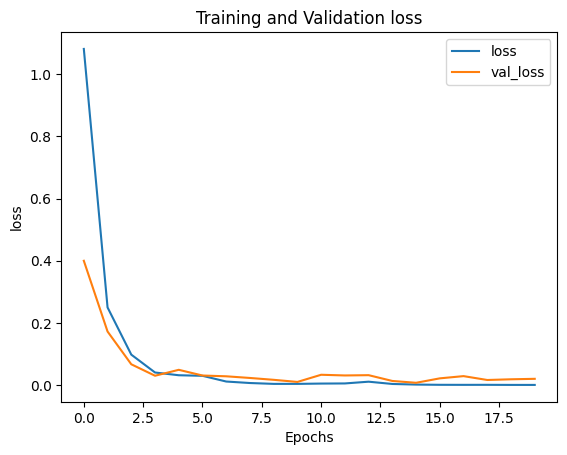

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.title('Training and Validation loss')
plt.show()

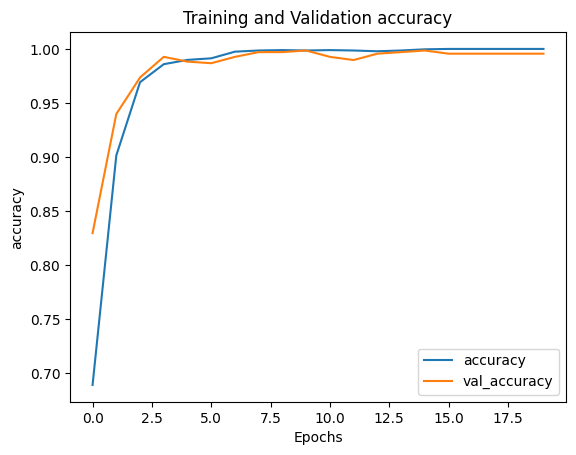

In [14]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Training and Validation accuracy')
plt.show()

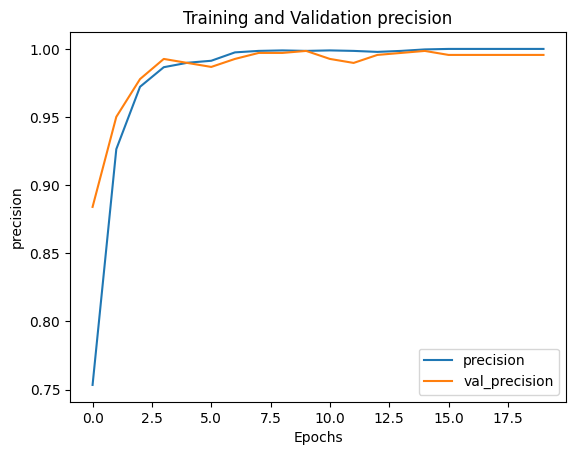

In [15]:
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='Validation precision')
plt.xlabel("Epochs")
plt.ylabel('precision')
plt.legend(['precision', 'val_precision'])
plt.title('Training and Validation precision')
plt.show()

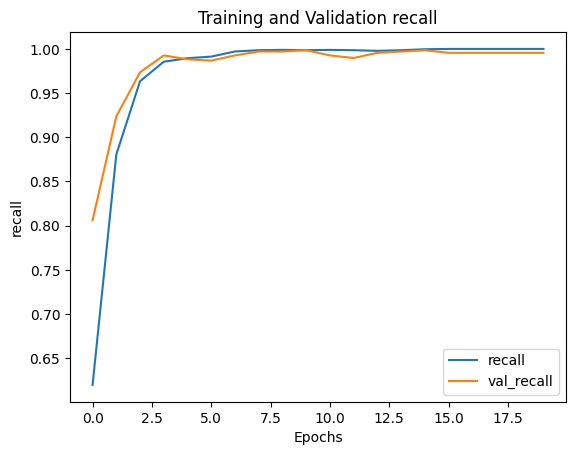

In [16]:
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='Validation recall')
plt.xlabel("Epochs")
plt.ylabel('recall')
plt.legend(['recall', 'val_recall'])
plt.title('Training and Validation recall')
plt.show()

22/22 [==============================] - 0s 2ms/step
Confusion Matrix
Accuracy for Test Data =  99.70588235294117


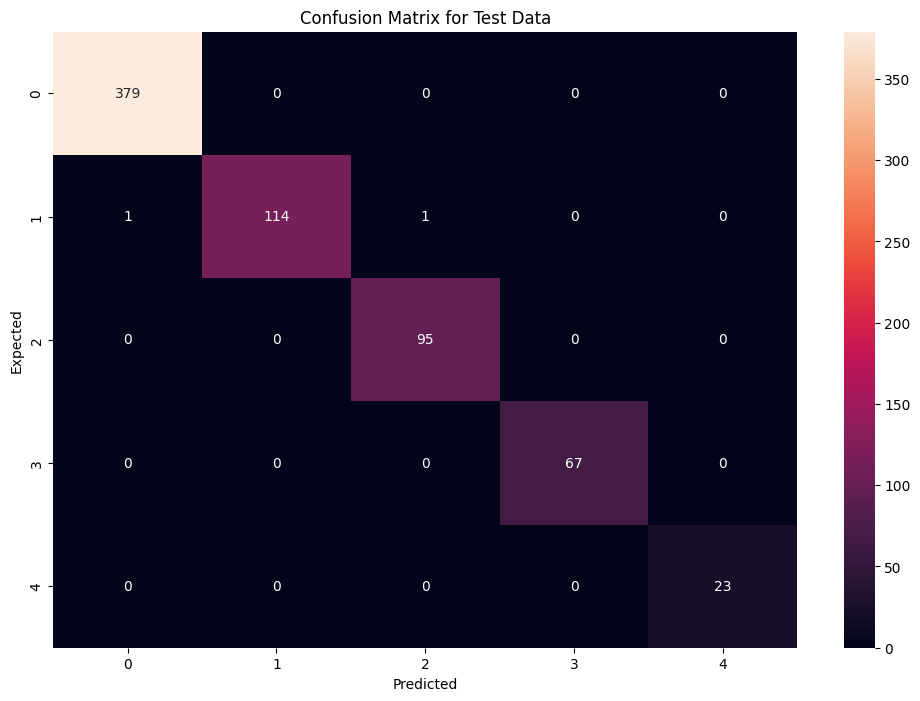


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       379
           1       1.00      0.98      0.99       116
           2       0.99      1.00      0.99        95
           3       1.00      1.00      1.00        67
           4       1.00      1.00      1.00        23

    accuracy                           1.00       680
   macro avg       1.00      1.00      1.00       680
weighted avg       1.00      1.00      1.00       680


Cohen Kappa Score
0.9953267495481379

Precision vs Recall Curve


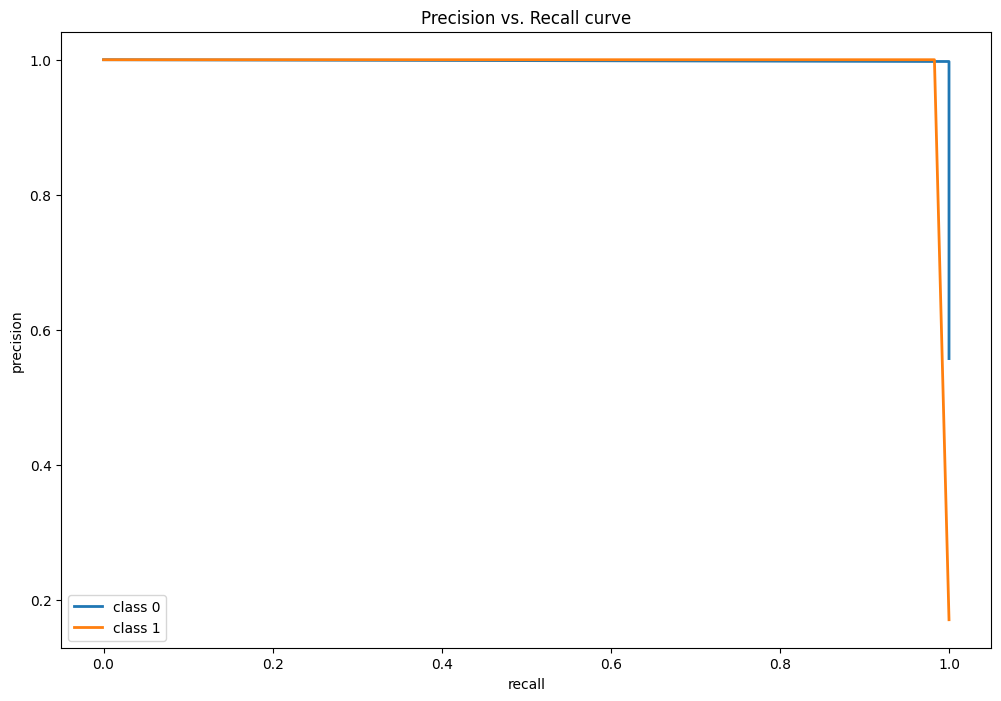


ROC Curve
ROC AUC score: 0.9977726959844041


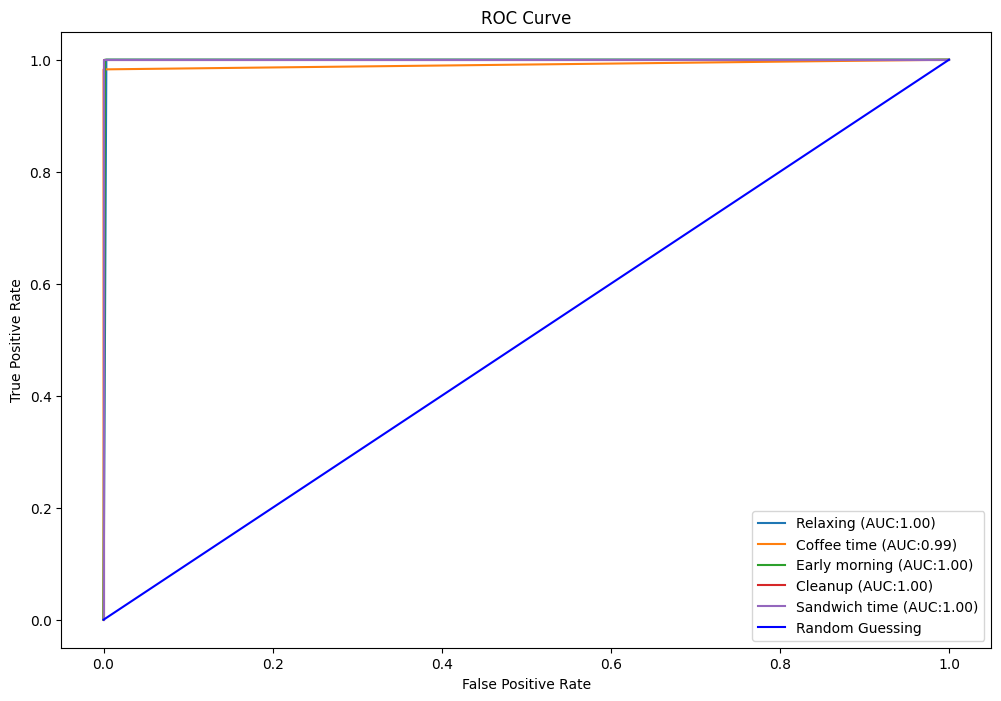

In [17]:
def model_evaluate(model, target, testX, testy):
  y_pred = model.predict(testX)
  y_pred = np.argmax(y_pred, axis=1)
  y_test = np.argmax(testy, axis=1)

  # Confusion matrix
  print('Confusion Matrix')

  cm = confusion_matrix(y_test, y_pred)
  # Calculate accuracy
  from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_curve, auc, roc_auc_score, precision_recall_curve
  conf_acc = accuracy_score(y_test, y_pred) * 100
  print("Accuracy for Test Data = ", conf_acc)

  plt.figure(figsize = (12,8))
  sns.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

  # Classification Report
  print('\nClassification Report')
  print(classification_report(y_test, y_pred))

  # Cohen Kappa Score
  print('\nCohen Kappa Score')
  print(cohen_kappa_score(y_test, y_pred))

  # Precision vs Recall Curve
  print('\nPrecision vs Recall Curve')
  fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

  y_test = tf.keras.utils.to_categorical(y_test)
  y_pred = tf.keras.utils.to_categorical(y_pred)
  n_classes = 2

  precision = dict()
  recall = dict()

  for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                          y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

  plt.xlabel("recall")
  plt.ylabel("precision")
  plt.legend(loc="best")
  plt.title("Precision vs. Recall curve")
  plt.show()

  # ROC Curve
  print('\nROC Curve')
  average = 'macro'
  fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
  for (idx, c_label) in enumerate(target):
      fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
      c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
  c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  print('ROC AUC score:', roc_auc_score(y_test, y_pred, average=average))

  c_ax.legend()
  c_ax.set_xlabel('False Positive Rate')
  c_ax.set_ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()

model_evaluate(model, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], X_test, y_test)

In [18]:
pd.DataFrame([[history.history['loss'][-1], history.history['accuracy'][-1], history.history['precision'][-1], history.history['recall'][-1], history.history['tp'][-1], history.history['tn'][-1], history.history['fn'][-1], history.history['fp'][-1], history.history['auc'][-1]]],  columns=["loss", "accuracy", "precision", "recall", "true positive", "true negative", "false positive", "false negative", "area under the curve"])

,loss,accuracy,precision,recall,true positive,true negative,false positive,false negative,area under the curve
0,0.000153,1.0,1.0,1.0,2761.0,11044.0,0.0,0.0,1.0
